# Support Vector Machine Classification

## 1. Read the Iris dataset

In [1]:
import pandas as pd
iris = pd.read_csv('Iris.csv', header = None)
# Create column labels
iris.columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Species']

## 2. Classify the training set
### 2.1. Try different sets of features

In [2]:
from sklearn.svm import SVC

# Define all possible sets of features
featureSets = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3],
               [0,1,2], [0,1,3], [0,2,3], [1,2,3],
               [0,1,2,3]]

# Run through all sets of features
for features in featureSets:
    # Assemble the training set 
    X = iris.iloc[:, features].values
    y = pd.factorize(iris['Species'].values)[0]
    # Training and training accuracy
    print("Features:", features, end = "\t")
    model = SVC()
    model.fit(X, y)
    accuracy = model.score(X, y)
    print("Accuracy:", accuracy)

Features: [0, 1]	Accuracy: 0.82
Features: [0, 2]	Accuracy: 0.96
Features: [0, 3]	Accuracy: 0.96
Features: [1, 2]	Accuracy: 0.9533333333333334
Features: [1, 3]	Accuracy: 0.96
Features: [2, 3]	Accuracy: 0.9533333333333334
Features: [0, 1, 2]	Accuracy: 0.9466666666666667
Features: [0, 1, 3]	Accuracy: 0.96
Features: [0, 2, 3]	Accuracy: 0.9666666666666667
Features: [1, 2, 3]	Accuracy: 0.9733333333333334
Features: [0, 1, 2, 3]	Accuracy: 0.9733333333333334


### 2.2. Confusion matrix

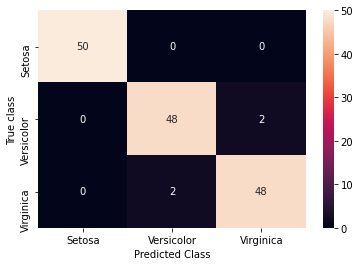

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the training set
features = [0,1,2,3]
X = iris.iloc[:,features].values
y = pd.factorize(iris['Species'].values)[0]

# Train the model and predict the class for each training set
model = SVC()
model.fit(X, y)
y_pred = model.predict(X)

# Calculate the confusion matrix
confusion = confusion_matrix(y, y_pred)

# Plot the confusion matrix as a heat map
def visualize_confusion_matrix(confusion):
    categories = ['Setosa', 'Versicolor', 'Virginica']
    sns.heatmap(confusion, annot = True, xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted Class")
    plt.ylabel("True class")
    plt.show()
    
visualize_confusion_matrix(confusion)

### 2.3. Classification regions

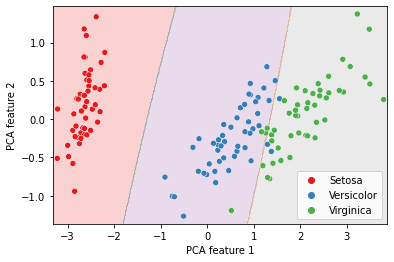

In [4]:
import numpy as np
from sklearn.decomposition import PCA as sklearnPCA

# Plot the decision boundaries
# If the number of features is more than 2, reduce dimensionality to 2
if len(features) > 2:
    pca = sklearnPCA(n_components = 2)
    pca.fit(X)
    X_pca = pca.transform(X)
else: 
    X_pca = X
# Determine the limits of the space
xMin, xMax = X_pca[:, 0].min() - 0.1, X_pca[:, 0].max() + 0.1
yMin, yMax = X_pca[:, 1].min() - 0.1, X_pca[:, 1].max() + 0.1
# Generate the 2D mesh for the decision surface
resolution = 0.02
xx, yy = np.meshgrid(np.arange(xMin, xMax, resolution), np.arange(yMin, yMax, resolution))
meshPts = np.array([xx.ravel(), yy.ravel()]).T
# Transform the mesh points back to the original space
if len(features) > 2:
    meshPts = pca.inverse_transform(meshPts)
# Predict the classification for the mesh points
predictedMesh = model.predict(meshPts)
predictedMesh = predictedMesh.reshape(xx.shape)
# Set up the figure
fig, ax =  plt.subplots(1,1)
# Plot the regions and decision boundaries using the mesh
plt.contourf(xx, yy, predictedMesh, alpha = 0.2, cmap = 'Set1')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
# Plot each category
sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = y, palette = 'Set1')
# Add axis labels 
if len(features) > 2:
    plt.xlabel("PCA feature 1")
    plt.ylabel("PCA feature 2")
else:
    plt.xlabel(iris.columns[features[0]])
    plt.ylabel(iris.columns[features[1]])
# Customize legend labels
handles, labels = ax.get_legend_handles_labels()
categories = ['Setosa', 'Versicolor', 'Virginica']
plt.legend(handles, categories)
plt.show()

## 3. Overfitting and underfitting

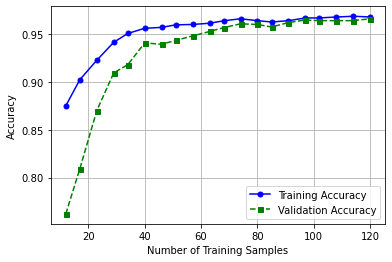

In [5]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit

# Generate the training set
features = [0,1,2,3]
X = iris.iloc[:,features].values
y = pd.factorize(iris['Species'].values)[0]

# Create the model
model = SVC()

# Test different training sizes
train_sizes = np.linspace(0.1, 1.0, 20)

# Create the cross validation objects
# Specify a large number of splits to average different trials and obtain a smoother curve
cv = StratifiedShuffleSplit(n_splits=50, test_size = 0.2, random_state=1)

# Generate the learning curves averages
train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes = train_sizes, cv = cv)
train_mean = np.mean(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)

# Plot the learning curves
plt.plot(train_sizes, train_mean, color = 'blue', marker = 'o', markersize = 5, label = 'Training Accuracy')
plt.plot(train_sizes, test_mean, color = 'green', marker = 's', linestyle = '--', markersize = 5, label = 'Validation Accuracy')
plt.grid()
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 4. Parameter setting
### 4.1. Validation curves
* Look at validation curves for different soft margin (regularization) parameters C
    * Linear kernel
    * Polynomial kernel
        * If the model underfits the data, increase the degree
        * If the model overfits the data, decrease the degree
    * RBF kernel
        * If the model underfits the data, increase gamma
        * If the model overfits the data, decrease gamma

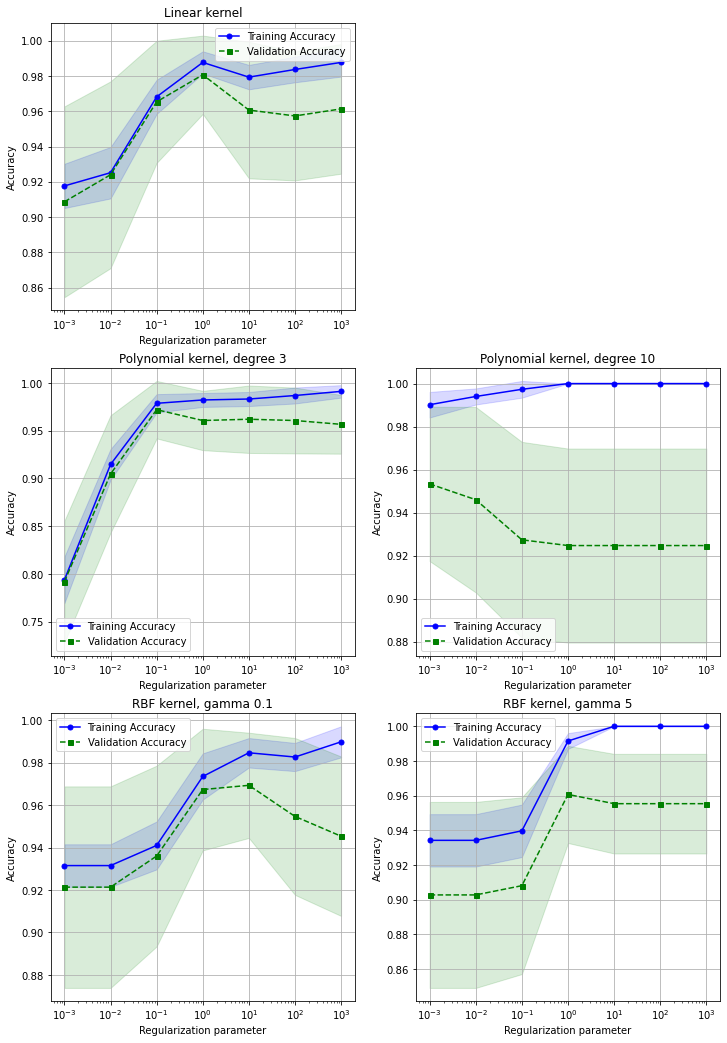

In [14]:
from sklearn.model_selection import validation_curve

# Generate the training set
features = [0,1,2,3]
X = iris.iloc[:,features].values
y = pd.factorize(iris['Species'].values)[0]

# Explore a range values for the regularization parameter
param_range = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]

''' Generate and plot validation curves '''
def generate_and_plot_validation_curves(model, ax):
    cv = StratifiedShuffleSplit(n_splits=50, test_size = 0.2, random_state=1)
    # Generate the validation curves averages and standard deviations 
    train_scores, test_scores = validation_curve(model, X, y, param_name = 'C', param_range = param_range, cv = cv)
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)

    # Plot the validation curves in the figure axis
    ax.plot(param_range, train_mean, color = 'blue', marker = 'o', markersize = 5, label = 'Training Accuracy')
    ax.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha = 0.15, color = 'blue')
    ax.plot(param_range, test_mean, color = 'green', marker = 's', linestyle = '--', markersize = 5, label = 'Validation Accuracy')
    ax.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha = 0.15, color = 'green')
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel('Regularization parameter')
    ax.set_ylabel('Accuracy')
    ax.legend()

# Generate the validation curves for a model using the linear kernel
fig, ax = plt.subplots(3, 2, figsize = (12,18))
model = SVC(kernel = 'linear')
generate_and_plot_validation_curves(model, ax[0][0])
ax[0][0].set_title('Linear kernel')
ax[0][1].get_xaxis().set_visible(False)
ax[0][1].get_yaxis().set_visible(False)
ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['bottom'].set_visible(False)
ax[0][1].spines['left'].set_visible(False)

# Generate the validation curves for a model using the polynomial kernel of degree 3
model = SVC(kernel = 'poly', degree = 3)
generate_and_plot_validation_curves(model, ax[1][0])
ax[1][0].set_title('Polynomial kernel, degree 3')

# Generate the validation curves for a model using the polynomial kernel of degree 10
model = SVC(kernel = 'poly', degree = 10)
generate_and_plot_validation_curves(model, ax[1][1])
ax[1][1].set_title('Polynomial kernel, degree 10')

# Generate the validation curves for a model using the RBF kernel with gamma 0.1
model = SVC(kernel = 'rbf', gamma = 0.1)
generate_and_plot_validation_curves(model, ax[2][0])
ax[2][0].set_title('RBF kernel, gamma 0.1')

# Generate the validation curves for a model using the RBF kernel with gamma 5
model = SVC(kernel = 'rbf', gamma = 5)
generate_and_plot_validation_curves(model, ax[2][1])
ax[2][1].set_title('RBF kernel, gamma 5')

plt.show()

### 4.2. Nested cross validation and grid search

F1 Score: 0.9799498746867169 +/- 0.01637085876546819


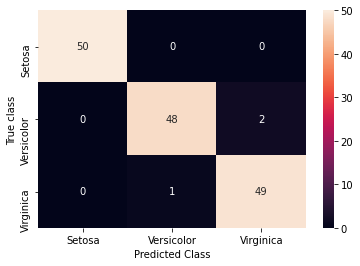

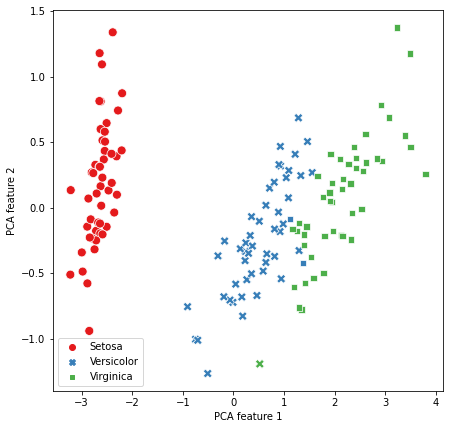

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Generate the training set
features = [0,1,2,3]
X = iris.iloc[:,features].values
y = pd.factorize(iris['Species'].values)[0]

# Create the model
model = SVC()

# Set up the grid of parameters and the grid search
hyperParams = [{'C': [0.01, 0.1, 1.0], 'kernel': ['linear']},
               {'C': [0.01, 0.1, 1.0], 'kernel': ['poly'], 'degree': [2, 3, 4]},
               {'C': [0.01, 0.1, 1.0], 'kernel': ['rbf'], 'gamma': [0.01, 0.1, 1.0]}]
search = GridSearchCV(model, hyperParams, cv = 2, scoring = 'f1_macro')

# Perform the cross validation
scores = cross_val_score(search, X, y, scoring = 'f1_macro', cv = 5)
print('F1 Score:', np.mean(scores), '+/-', np.std(scores))

# Show the confusion matrix
y_pred = cross_val_predict(search, X, y, cv = 5)
conf = confusion_matrix(y, y_pred)
visualize_confusion_matrix(conf)

# Show the classification plot
def visualize_classification(X, y, y_pred):
    fig, ax = plt.subplots(1, 1, figsize = (7,7))
    # If the number of features is more than 2, use the PCA components for plotting
    if len(features) > 2:
        xAxis = X_pca[:,0]
        yAxis = X_pca[:,1]
    else:
        xAxis = X[:,features[0]]
        yAxis = X[:,features[1]]
    # Scatter plot of the data
    # Points color is the true class
    # Points marker is the predicted class
    sns.scatterplot(x = xAxis, y = yAxis, hue = y, style = y_pred, s = 80, palette = 'Set1')
    # Add axis labels 
    if len(features) > 2:
        plt.xlabel("PCA feature 1")
        plt.ylabel("PCA feature 2")
    else:
        plt.xlabel(iris.columns[features[0]])
        plt.ylabel(iris.columns[features[1]])
    # Customize legend labels
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, categories)
    plt.show()
    
visualize_classification(X, y, y_pred)

### 4.3. Best parameters

In [18]:
from sklearn.model_selection import train_test_split

# Create the model
model = SVC()

# Set up the grid of parameters and the grid search
hyperParams = [{'C': [0.01, 0.1, 1.0], 'kernel': ['linear']},
               {'C': [0.01, 0.1, 1.0], 'kernel': ['poly'], 'degree': [2, 3, 4]},
               {'C': [0.01, 0.1, 1.0], 'kernel': ['rbf'], 'gamma': [0.01, 0.1, 1.0]}]
search = GridSearchCV(model, hyperParams, cv = 5, scoring = 'f1_macro')

# Generate random training and test sets
# Create the iris categories so that the conversion from a category to a number is always the same across different splits
irisCategories = pd.factorize(iris['Species'].values)[0]
X_train, X_test, y_train, y_test = train_test_split(iris, irisCategories, test_size = 0.2, shuffle = True, stratify = iris['Species'])

# Train the model using the training set 
#search.fit(X_train.iloc[:,features], y_train)
search.fit(iris.iloc[:,features], irisCategories)

# Look at scores
results = pd.DataFrame.from_dict(search.cv_results_)
print("Best score:", search.best_score_)
print("Best parameters:", search.best_params_)
results

Best score: 0.9866332497911445
Best parameters: {'C': 0.1, 'degree': 3, 'kernel': 'poly'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_degree,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003082,0.000596,0.002759,0.000711,0.01,linear,NaN,NaN,"{'C': 0.01, 'kernel': 'linear'}",0.899749,0.966583,0.865320,0.966583,0.897698,0.919187,0.040581,16
1,0.002017,0.000021,0.001601,0.000491,0.1,linear,NaN,NaN,"{'C': 0.1, 'kernel': 'linear'}",0.966583,0.966583,0.966583,0.966583,1.000000,0.973266,0.013367,7
2,0.001598,0.000486,0.002002,0.000637,1,linear,NaN,NaN,"{'C': 1.0, 'kernel': 'linear'}",0.966583,1.000000,0.966583,0.966583,1.000000,0.979950,0.016371,3
3,0.002013,0.000039,0.001786,0.000404,0.01,poly,2,NaN,"{'C': 0.01, 'degree': 2, 'kernel': 'poly'}",0.899471,0.864697,0.829497,0.897698,0.795455,0.857364,0.040157,21
4,0.001797,0.000399,0.001392,0.000484,0.01,poly,3,NaN,"{'C': 0.01, 'degree': 3, 'kernel': 'poly'}",0.899749,0.932660,0.899749,0.932660,0.864697,0.905903,0.025320,20
5,0.001611,0.000494,0.001789,0.000395,0.01,poly,4,NaN,"{'C': 0.01, 'degree': 4, 'kernel': 'poly'}",0.966583,1.000000,0.933333,0.899749,1.000000,0.959933,0.038948,11
6,0.001600,0.000488,0.001398,0.000489,0.1,poly,2,NaN,"{'C': 0.1, 'degree': 2, 'kernel': 'poly'}",0.899749,0.966583,0.933333,0.899749,1.000000,0.939883,0.038965,13
7,0.002413,0.000515,0.002218,0.000391,0.1,poly,3,NaN,"{'C': 0.1, 'degree': 3, 'kernel': 'poly'}",0.966583,1.000000,1.000000,0.966583,1.000000,0.986633,0.016371,1
8,0.002794,0.000739,0.001789,0.000743,0.1,poly,4,NaN,"{'C': 0.1, 'degree': 4, 'kernel': 'poly'}",0.966583,1.000000,0.966583,0.966583,1.000000,0.979950,0.016371,3
9,0.002042,0.000069,0.001602,0.000491,1,poly,2,NaN,"{'C': 1.0, 'degree': 2, 'kernel': 'poly'}",0.966583,1.000000,1.000000,0.966583,1.000000,0.986633,0.016371,1


## 5. Cross validation
### 5.1. Accuracy

In [20]:
from sklearn.model_selection import cross_val_score

# Generate the training set
features = [0,1,2,3]
X = iris.iloc[:,features].values
y = pd.factorize(iris['Species'].values)[0]

# Create the model
model = SVC(C = 0.1, kernel = 'poly', degree = 3)

# Stratified cross validation is used, cv specifies the number of folds
cross_val_score(model, X, y, cv = 5, scoring = "accuracy")

array([0.96666667, 1.        , 1.        , 0.96666667, 1.        ])

### 5.2. Confusion matrix

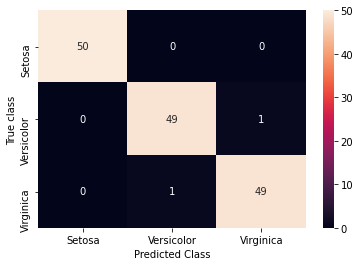

In [21]:
# First predict the classification for each sample using cross validation
from sklearn.model_selection import cross_val_predict
# Stratified cross validation is used, cv specifies the number of folds
y_pred = cross_val_predict(model, X, y, cv = 5)

# Compare the expected class and the predicted class
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y, y_pred)

# Plot the confusion matrix as a heat map
visualize_confusion_matrix(conf)

### 5.3. Precision, recall, and f1 score

In [22]:
# Calculate the prediction, recall, and f1 score using expected class and predicted class
from sklearn.metrics import precision_score, recall_score, f1_score

# This is not a binary classification, so we need to decide how to calculate TP, FP, TN, and FN
# micro: Calculate metrics globally by counting the total true positives, false negatives and false positives
# macro: Calculate metrics for each label, and find their unweighted mean which does not take label imbalance into account
combine_criterion = "macro"
precision = precision_score(y, y_pred, average = combine_criterion)
recall = recall_score(y, y_pred, average = combine_criterion)
f1 = f1_score(y, y_pred, average = combine_criterion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9866666666666667
Recall: 0.9866666666666667
F1 Score: 0.9866666666666667


### 5.4. Visualization

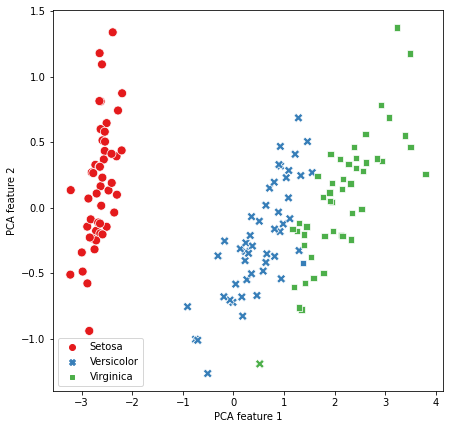

In [23]:
visualize_classification(X, y, y_pred)